# In this notebook I write the routine for flight-path calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - the peak positions are detected and single edge fitting is applied
        - calculate L, T0 or deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
        
       Convertion between time of flight and neutron wavelenght can be done after flight-path calibration: the value of the distance between the source and the transmission detector L0  and the time delay of the source trigger DT0, is obtained by linear regression to the function  lambda = h/mL (t-t0), or t= lambda(mL/h)+t0, with h= Planck constant
                    
        

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
%matplotlib inline
import scipy.signal
print(scipy.__version__)
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import AdvancedBraggEdgeFitting
import seaborn as sns
sns.set()

1.1.0


In [2]:
# Constant values
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]
#theoretical numbers
t0=0
L= 56.4 #[m]
dL = 0

In [3]:
def tof2l(tof):
    l=h/m*(tof-t0)/(L+dL)/1e-10
    return l

def l2tof(l):
    tof=t0+(l*1e-10)*(L+dL)*m/h
    return tof

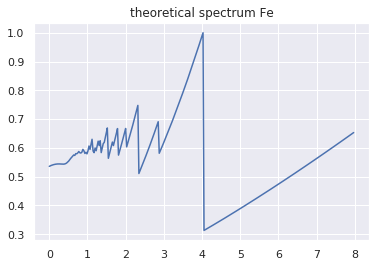

In [4]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myspectrum = np.genfromtxt('alpha.txt',usecols=0)

# print(mylambda)
mytof = l2tof(mylambda)
relambda = tof2l(mytof)
plt.plot(mylambda, myspectrum/max(myspectrum))
plt.title('theoretical spectrum Fe')
plt.show()


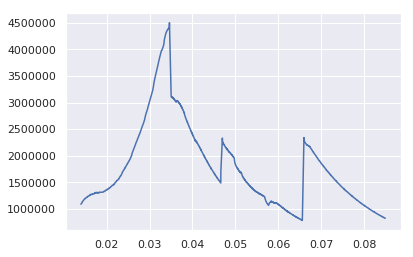

In [5]:
# Read the calibration spectrum from file
mycaltof = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=0)
myhist = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)



plt.plot(mycaltof,myhist)
plt.show()

In [6]:
# Read the calibration datasets:
# pathdata ="/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/"
# pathOB = "/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/flat_after_reboot_OC_Fiji/"

pathdata ="/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Samples_AfterReboot_Corrected/"
pathOB = "/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Flat_AfterReboot_Corrected/"

In [7]:
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)
print(coll_files[504])
print(coll_files[505])
print(coll_files[506])

obfiles = fnmatch.filter(listdir(pathOB),'*.fits') # here there are several OB folders
coll_ob = sorted(obfiles)
print(coll_ob[504])
print(coll_ob[505])
print(coll_ob[506])
# print(sorted(obfiles))

IMAT00010420_HighStats_Radio_1hruns_000_000504.fits
IMAT00010420_HighStats_Radio_1hruns_000_100000.fits
IMAT00010420_HighStats_Radio_1hruns_000_100001.fits
IMAT00010421_HighStats_Radio_1hruns_000_000504.fits
IMAT00010421_HighStats_Radio_1hruns_000_100000.fits
IMAT00010421_HighStats_Radio_1hruns_000_100001.fits


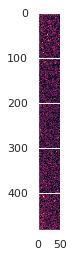

In [9]:
roi_cal = np.array([6,16,57,500])
filename = pathdata + coll_files[0]
im = fits.open(filename)
# plt.imshow(im[0].data)
plt.imshow(im[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]) #this is the area that I want to study

In [10]:
cal_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))

for i in range(0, len(coll_files)):
    
    curr_img = (fits.open(pathdata+coll_files[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    curr_ob =(fits.open(pathOB+coll_ob[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
    cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    
    

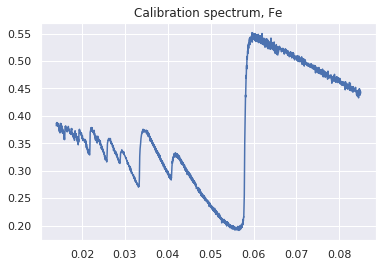

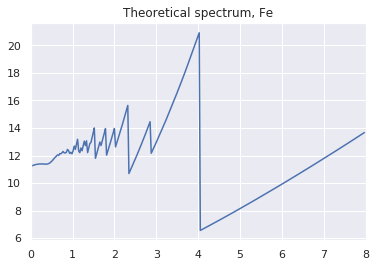

In [11]:
cal_spectrum_norm = cal_spectrum/cal_ob
mycalLambda = tof2l(mycaltof)
plt.plot(mycaltof, (cal_spectrum/cal_ob))
plt.title('Calibration spectrum, Fe')
# plt.xlim(0,8)
plt.show()

np.savetxt('spectrum_cal_transmission.txt', cal_spectrum/cal_ob)
np.savetxt('tof.txt', mycaltof)

myspectrum_norm = myspectrum/np.average(myspectrum)
plt.plot(mylambda, myspectrum)
plt.title('Theoretical spectrum, Fe')
plt.xlim(0,8)
plt.show()

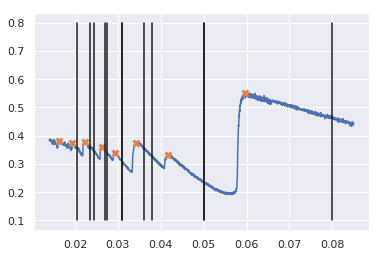

[0.0162118 0.0194067 0.022233  0.026329  0.0292781 0.0342342 0.0416982
 0.0596195]
[  54  132  201  301  373  494  833 1692]


/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

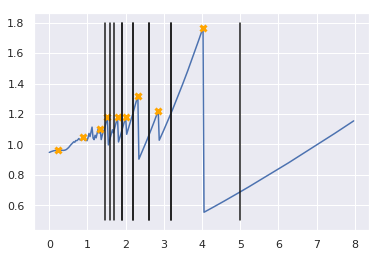

[0.24  0.88  1.333 1.52  1.787 2.    2.32  2.853 4.027]


In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx)

lambda_ranges=np.zeros((6,2))


lambda_ranges[5,0] = 3.2
lambda_ranges[5,1] = 5.0

lambda_ranges[4,0] = 2.6
lambda_ranges[4,1] = 3.2

lambda_ranges[3,0] = 2.2
lambda_ranges[3,1] = 2.6

lambda_ranges[2,0] = 1.9
lambda_ranges[2,1] = 2.2

lambda_ranges[1,0] = 1.7
lambda_ranges[1,1] = 1.9

lambda_ranges[0,0] = 1.45
lambda_ranges[0,1] = 1.6

tof_ranges=np.zeros((6,2))

tof_ranges[5,0] = 0.05
tof_ranges[5,1] = 0.08

tof_ranges[4,0] =  0.038
tof_ranges[4,1] =  0.05

tof_ranges[3,0] = 0.031
tof_ranges[3,1] = 0.036

tof_ranges[2,0] = 0.0275
tof_ranges[2,1] =  0.031

tof_ranges[1,0] = 0.0245
tof_ranges[1,1] =  0.027

tof_ranges[0,0] = 0.0205
tof_ranges[0,1] =  0.0235

# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
peaks, _ = find_peaks(cal_spectrum_norm, width=15)
plt.plot(mycaltof, cal_spectrum_norm)
plt.plot(mycaltof[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
for i in range(0,6):
    plt.plot((tof_ranges[i,0], tof_ranges[i,0]),(0.1,0.8), 'k-')
    plt.plot((tof_ranges[i,1], tof_ranges[i,1]),(0.1,0.8), 'k-')
# plt.ylim(0.8,1.02)
plt.show()
print(mycaltof[peaks])
print(peaks)

# print(find_nearest(mycaltof, tof_ranges[0,0]))
      

resamp_spectrum = scipy.signal.resample(myspectrum_norm, len(myspectrum_norm)*5)
# plt.plot(resamp_spectrum)
peaks_th, _ = find_peaks(myspectrum_norm, width=2)
plt.plot(mylambda, myspectrum_norm)
plt.plot(mylambda[peaks_th],myspectrum_norm[peaks_th],'x', markeredgewidth=3, c='orange')
for i in range(0,6):
    plt.plot((lambda_ranges[i,0], lambda_ranges[i,0]),(0.5,1.8), 'k-')
    plt.plot((lambda_ranges[i,1], lambda_ranges[i,1]),(0.5,1.8), 'k-')
# plt.ylim(0.3,1.02)
plt.show()
print(mylambda[peaks_th])

---- Peak positions given by the lattice parameters ----
[4.054 2.866 2.34  2.026 1.812 1.654 1.532 1.434 1.352 1.352 1.282 1.222
 1.17  1.124 1.124 1.046 1.014 0.984 0.984 0.956 0.956 0.93  0.93  0.906
 0.884 0.864 0.846 0.828 0.81  0.81  0.81  0.794 0.78  0.78  0.78  0.766
 0.752 0.728 0.728 0.716 0.706 0.706 0.706 0.696 0.696 0.686 0.676 0.676
 0.666 0.666 0.666 0.658 0.65  0.64  0.632 0.626 0.618 0.618 0.612 0.604
 0.604 0.592 0.586 0.58  0.58  0.574 0.568 0.562 0.552 0.546 0.536 0.536
 0.536 0.532 0.518 0.506 0.498 0.496 0.492 0.488 0.478 0.45  0.448 0.414]


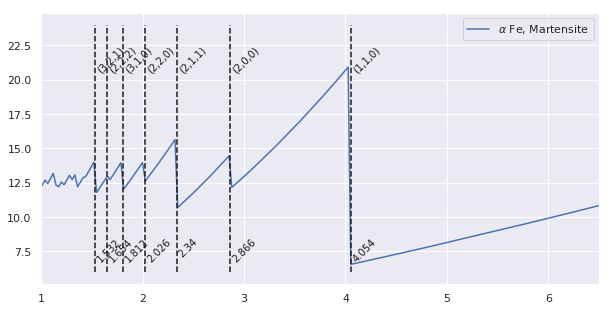

In [13]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(mylambda, myalpha, label=r'$\alpha$ Fe, Martensite')

for i in range(0,7):
    plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([6,24]), '--k')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],22, mytext, rotation=45, color='k')
    plt.text(2*dhkl_alphaFe[i],8, str(2*dhkl_alphaFe[i]), rotation=45, color='k')

plt.legend(loc='upper right')
plt.xlim(1,6.5)

print('---- Peak positions given by the lattice parameters ----')
print(dhkl_alphaFe*2)

[  54  132  201  301  373  494  833 1692]
[  9  33  50  57  67  75  87 107 151]
[ 57  67  75  87 107 151]
--- RefPoints obtained from lattice parameters ---
[1.532 1.812 2.026 2.34  2.866 4.054]
8
[0.0205 0.0235]
[159 232]
201
-----------Fitting calibration Bragg Edge--------------


/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: invalid value encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 73
    # variables        = 7
    chi-square         = 8.3350e-04
    reduced chi-square = 1.2629e-05
    Akaike info crit   = -816.764702
    Bayesian info crit = -800.731486
[[Variables]]
    t0:     33.1803348 (init = 33.13472)
    sigma: -1.28982709 (init = -1.12185)
    alpha: -0.14898084 (init = -0.07720797)
    a1:    -213.468761 (init = -198.5366)
    a2:    -7.7181e-04 (init = -0.0007185103)
    a5:    -7.7201e-04 (init = -0.0007186977)
    a6:     277074.995 (init = 276846)



/home/carminati_c/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:767: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/carminati_c/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:774: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


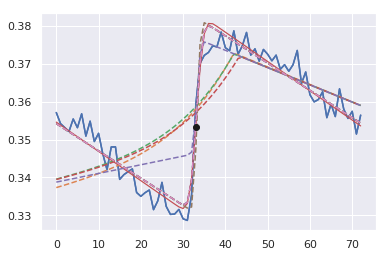

-----------Results of fitting, Edge Position, TOF and lambda:------------
33.18033478991402
0.0218643
[0.0218643 0.        0.        0.        0.        0.       ]
[0.0245 0.027 ]
[256 317]
301
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 61
    # variables        = 7
    chi-square         = 5.5558e-04
    reduced chi-square = 1.0289e-05
    Akaike info crit   = -693.988651
    Bayesian info crit = -679.212534
[[Variables]]
    t0:     34.6502908 (init = 34.63317)
    sigma: -2.15079922 (init = -1.931443)
    alpha: -0.07770786 (init = -0.07770787)
    a1:    -157.728838 (init = -146.4167)
    a2:    -6.4015e-04 (init = -0.0005943384)
    a5:    -6.4033e-04 (init = -0.0005945119)
    a6:     246961.897 (init = 246961.9)



/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:45: RuntimeWarning: invalid value encountered in multiply
  return (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


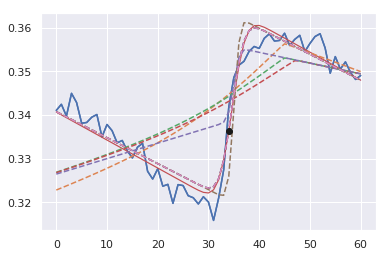

-----------Results of fitting, Edge Position, TOF and lambda:------------
34.650290756872785
0.0258784
[0.0218643 0.0258784 0.        0.        0.        0.       ]
[0.0275 0.031 ]
[330 415]
373
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 85
    # variables        = 7
    chi-square         = 3.0786e-04
    reduced chi-square = 3.9469e-06
    Akaike info crit   = -1050.92380
    Bayesian info crit = -1033.82524
[[Variables]]
    t0:     35.8613592 (init = 35.69707)
    sigma: -3.17850548 (init = -2.652793)
    alpha: -0.14078441 (init = -0.2413421)
    a1:    -107.283353 (init = -100.0971)
    a2:    -7.1605e-04 (init = -0.0006689932)
    a5:    -7.1626e-04 (init = -0.0006691906)
    a6:     150320.687 (init = 150148.8)



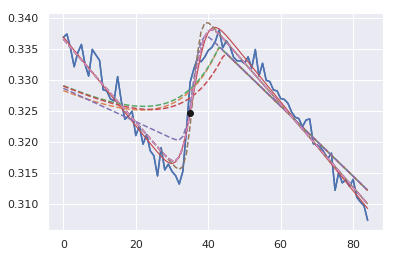

-----------Results of fitting, Edge Position, TOF and lambda:------------
35.86135921385318
0.0289504
[0.0218643 0.0258784 0.0289504 0.        0.        0.       ]
[0.031 0.036]
[415 555]
494
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 140
    # variables        = 7
    chi-square         = 0.00433259
    reduced chi-square = 3.2576e-05
    Akaike info crit   = -1439.65238
    Bayesian info crit = -1419.06088
[[Variables]]
    t0:     62.1228763 (init = 62.24394)
    sigma: -4.73925805 (init = -4.288826)
    alpha: -0.53348708 (init = -0.3821077)
    a1:    -39.5473713 (init = -31.59323)
    a2:    -3.9338e-04 (init = -0.0003177678)
    a5:    -3.9445e-04 (init = -0.0003187748)
    a6:     101431.401 (init = 100524.5)



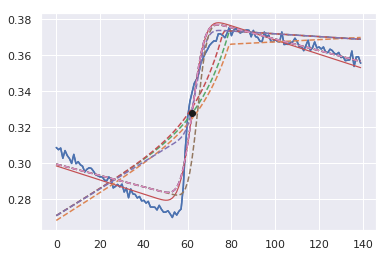

-----------Results of fitting, Edge Position, TOF and lambda:------------
62.122876301139044
0.0335379
[0.0218643 0.0258784 0.0289504 0.0335379 0.        0.       ]
[0.038 0.05 ]
[ 652 1222]
833
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 374
    # data points      = 570
    # variables        = 7
    chi-square         = 0.00478211
    reduced chi-square = 8.4940e-06
    Akaike info crit   = -6648.45108
    Bayesian info crit = -6618.03162
[[Variables]]
    t0:     151.909224 (init = 153.7881)
    sigma: -12.5700903 (init = -12.63838)
    alpha: -0.73863013 (init = -1.650941)
    a1:    -46.8245581 (init = -0.1430337)
    a2:    -2.6029e-04 (init = -0.0002490227)
    a5:    -2.6062e-04 (init = -0.000279605)
    a6:     181241.562 (init = 1989.479)



/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: overflow encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


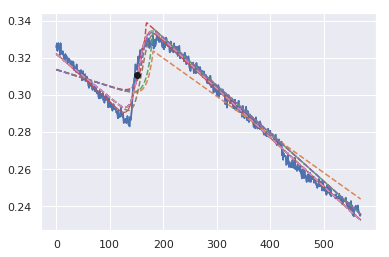

-----------Results of fitting, Edge Position, TOF and lambda:------------
151.9092237030303
0.0410838
[0.0218643 0.0258784 0.0289504 0.0335379 0.0410838 0.       ]
[0.05 0.08]
[1222 2329]
1692
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 298
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.06895886
    reduced chi-square = 6.2690e-05
    Akaike info crit   = -10705.8052
    Bayesian info crit = -10670.7393
[[Variables]]
    t0:     392.840242 +/- 0.19428554 (0.05%) (init = 394.9238)
    sigma: -16.2685435 +/- 0.29752442 (1.83%) (init = -15.15233)
    alpha: -3.97933572 +/- 18.3093328 (460.11%) (init = -1.494008)
    a1:    -19.3790958 +/- 41.3206130 (213.22%) (init = 0.1233344)
    a2:    -1.2043e-04 +/- 2.3648e-06 (1.96%) (init = -7.895091e-05)
    a5:    -1.2272e-04 +/- 3.2448e-06 (2.64%) (init = -0.000186239

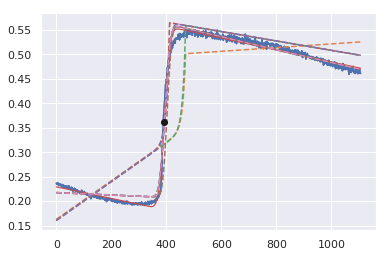

-----------Results of fitting, Edge Position, TOF and lambda:------------
392.84024243361034
0.0580221
[0.0218643 0.0258784 0.0289504 0.0335379 0.0410838 0.0580221]


In [14]:
#Here I try to use the BE Advanced fitting to fit single edges
print(peaks) # here I see which are the positions of the peaks in the cal spectrum
print(peaks_th) # position of the peaks in the theoretical spectrum

# Here I have to loop over the found peaks and fit with the AdvancedBraggEdgeFiltering, I take the 6 peaks found in the cal spectrum and define some range

# first I remove the more peaks that I have in the theoretical spectrum
peaks_ref= peaks_th[-6:]
print(peaks_ref)

est_sigma= -0.1
est_alpha= -10
CalPoints = np.zeros(6)
RefPoints = np.zeros(6)

RefPoints[0]=dhkl_alphaFe[6]*2

for i in range(1, 6):
    RefPoints[i]=dhkl_alphaFe[5-i]*2
#     RefPoints[i,0]=l2tof(RefPoints[i,1])

print('--- RefPoints obtained from lattice parameters ---')
print(RefPoints)
print(len(peaks))

for i in range(0, len(peaks)-2):
    
    print(tof_ranges[i,:])
    myrange = np.array([find_nearest(mycaltof, tof_ranges[i,0]), find_nearest(mycaltof,tof_ranges[i,1])])
    print(myrange)
    print(peaks[i+2])
            

    print('-----------Fitting calibration Bragg Edge--------------')

    results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha, False, False)
    print('-----------Results of fitting, Edge Position, TOF and lambda:------------')
    print(results_cal['t0'])
    print(mycaltof[myrange[0]+int(results_cal['t0'])])
    CalPoints[i] = mycaltof[myrange[0]+int(results_cal['t0'])]

    print(CalPoints)
#     print(RefPoints)

## I will then fit the calculated TOF to the theoretical lambda, x= RefPoints (theoretical lambda) y=mycaltof (computed TOF) 

[1.532 1.812 2.026 2.34  2.866 4.054]
[0.0218643 0.0258784 0.0289504 0.0335379 0.0410838 0.0580221]
[6.97140215e+01 6.04714249e-03]


Text(0.5, 0, 'ToF measured [s]')

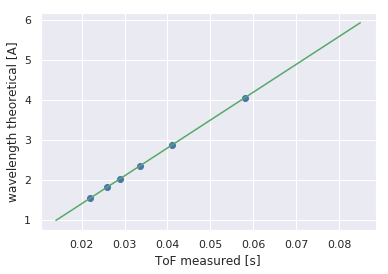

In [30]:
#Calibration on the lattice parameters value
print(RefPoints) # theoretical lambda
print(CalPoints) # calculated TOF

z= np.polyfit( CalPoints,RefPoints,1)
print(z)


plt.plot(CalPoints,RefPoints,'ob')
# plt.plot( mytof, mylambda,'-r')
plt.plot( mycaltof, mycaltof*z[0]+z[1],'-g')
# # plt.xlim(1,5)
plt.ylabel('wavelength theoretical [A]')
plt.xlabel('ToF measured [s]')
# # plt.ylim(0.0,0.03)
# plt.legend(['calibration points','theoretical curve', 'fit'])
# plt.title('Calibration plot')

In [24]:
# This is instead to compute l0 and L
lambda0 = z[1]
L = (h/(m*z[0]))/1e-10
print(lambda0,L,l2tof(lambda0))

0.006047142487771721 56.74660456761145 8.674212674292963e-05


(2451,)


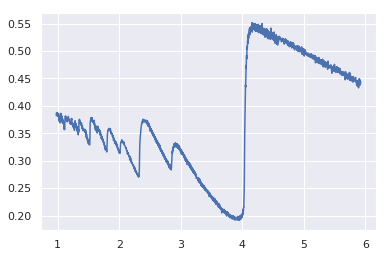

In [33]:
cal_lambda=tof2l(mycaltof)
print(np.shape(cal_lambda))
plt.figure()
plt.plot(cal_lambda, cal_spectrum_norm)

np.savetxt('lambda.txt', cal_lambda)

# My final result for IMAT flight-path calibration:
## L = 56.74 m
## lambda0 = 0.006
## T0 = 0.0002466


## Some tests here to get the peak height 

[159 232]
54
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 73
    # variables        = 7
    chi-square         = 8.3350e-04
    reduced chi-square = 1.2629e-05
    Akaike info crit   = -816.764702
    Bayesian info crit = -800.731486
[[Variables]]
    t0:     33.1803348 (init = 33.13472)
    sigma: -1.28982709 (init = -1.12185)
    alpha: -0.14898084 (init = -0.07720797)
    a1:    -213.468761 (init = -198.5366)
    a2:    -7.7181e-04 (init = -0.0007185103)
    a5:    -7.7201e-04 (init = -0.0007186977)
    a6:     277074.995 (init = 276846)



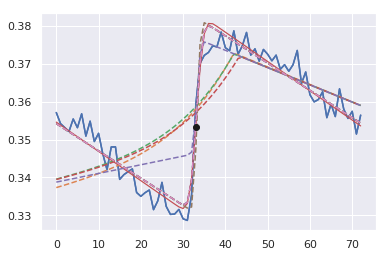

-----------Results of fitting, Edge Position, TOF and lambda:------------
0.0218643 1.5336155037339716


In [39]:
# I'll do again a single BE fitting to understand how to get pick height
for i in range(0, 1):
    
    myrange = np.array([find_nearest(mycaltof, tof_ranges[i,0]), find_nearest(mycaltof,tof_ranges[i,1])])
#     myrange = np.array([find_nearest(mycalLambda, lambda_ranges[i,0]), find_nearest(mycalLambda,lambda_ranges[i,1])])
#     range_ref = np.array([find_nearest(mylambda, lambda_ranges[i,0]), find_nearest(mylambda, lambda_ranges[i,1])])
    print(myrange)
    print(peaks[i])
#     print(range_ref)
            

    print('-----------Fitting calibration Bragg Edge--------------')

    results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha, False, False)
    print('-----------Results of fitting, Edge Position, TOF and lambda:------------')
    print(mycaltof[myrange[0]+int(results_cal['t0'])], mycalLambda[myrange[0]+int(results_cal['t0'])])

t0=results_cal['t0']
sigma = results_cal['sigma']
alpha = results_cal['alpha']
a1 = results_cal['a1']
a2 = results_cal['a2']
a5 = results_cal['a5']
a6 = results_cal['a6']
results = results_cal['final_result']



33.18033478991402
0.35337180064865853
0.3322423112104926
0.3805166446143188
peak height:  0.0482743334038262


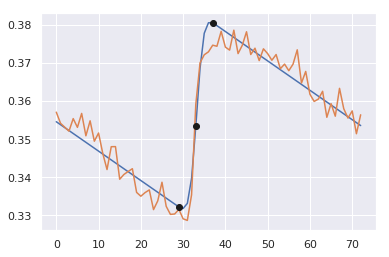

In [43]:
fit = results.best_fit
print(t0)
plt.plot(fit)
plt.plot(results.data)
plt.plot(int(t0),fit[int(t0)],'ok')
plt.plot(int(t0+3*sigma), fit[int(t0+3*sigma)], 'ok')
plt.plot(int(t0-3*sigma), fit[int(t0-3*sigma)], 'ok')

print(fit[int(t0)])
print(fit[int(t0+3*sigma)])
print(fit[int(t0-3*sigma)])
print('peak height: ', np.abs(fit[int(t0-3*sigma)]-fit[int(t0+3*sigma)])) # i must say that it works but not for all cases 